In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA,KernelPCA
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV


### Practise data set
We will be using the numerai data set for example

In [2]:
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
train = pd.read_csv('numerai_datasets/numerai_training_data.csv', header=0)
# The tournament data is the data that Numerai uses to evaluate your model.
tournament = pd.read_csv('numerai_datasets/numerai_tournament_data.csv', header=0)

# Loading data...


In [3]:
# The tournament data contains validation data, test data and live data.
# Validation is used to test your model locally so we separate that.
validation = tournament[tournament['data_type']=='validation']
test = tournament[tournament['data_type']=='test']
live = tournament[tournament['data_type']=='live']

In [4]:
print(train.shape)
print(tournament.shape)
print(live.shape)
print(test.shape)

(393613, 58)
(243037, 58)
(4070, 58)
(192605, 58)


In [5]:
train_bernie = train.drop([
    'id', 'era', 'data_type',
    'target_charles', 'target_elizabeth',
    'target_jordan', 'target_ken'], axis=1)

### Scikit Pipeline method

In [6]:
# Transform the loaded CSV data into numpy arrays
features = [f for f in list(train_bernie) if "feature" in f]
X_train = train_bernie[features]
y_train = train_bernie['target_bernie']
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca_n_dim=pca.explained_variance_ratio_.cumsum()
n_dim=np.argwhere(pca_n_dim>0.9)[0]
X_train = train_bernie[features]
y_train = train_bernie['target_bernie']
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=n_dim[0]),LogisticRegression(random_state=1,penalty='l1',C=0.01))
#pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=5),SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0))
pipe_lr.fit(X_train, y_train)
validation_bernie = validation.drop([
    'id', 'era', 'data_type',
    'target_charles', 'target_elizabeth',
    'target_jordan', 'target_ken'], axis=1)
# Transform the loaded CSV data into numpy arrays
features = [f for f in list(validation_bernie) if "feature" in f]
X_test = validation_bernie[features]
y_test = validation_bernie['target_bernie']

y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
print('Log loss : %.3f' % log_loss(y_test,pipe_lr.predict_proba(X_test)))

Test Accuracy: 0.516
Log loss : 0.692


### K-Fold cross validation

In [7]:
X_train = train_bernie[features].values
y_train = train_bernie['target_bernie'].values
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=n_dim[0]),LogisticRegression(random_state=1,solver='lbfgs'))
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [177153 177098], Acc: 0.518
Fold:  2, Class dist.: [177153 177098], Acc: 0.516
Fold:  3, Class dist.: [177153 177098], Acc: 0.513
Fold:  4, Class dist.: [177153 177098], Acc: 0.515
Fold:  5, Class dist.: [177153 177098], Acc: 0.498
Fold:  6, Class dist.: [177153 177098], Acc: 0.503
Fold:  7, Class dist.: [177153 177099], Acc: 0.517
Fold:  8, Class dist.: [177154 177099], Acc: 0.516
Fold:  9, Class dist.: [177154 177099], Acc: 0.507
Fold: 10, Class dist.: [177154 177099], Acc: 0.512

CV accuracy: 0.511 +/- 0.006


### Testing no of jobs

In [8]:
%%timeit -n 1 -r 1
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.5175296  0.51603069 0.51277882 0.51524313 0.49796758 0.50348051
 0.51650111 0.51575203 0.5070376  0.51161077]
CV accuracy: 0.511 +/- 0.006
40.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n 1 -r 1
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.51747879 0.51603069 0.51277882 0.51521772 0.49799299 0.50350592
 0.51650111 0.51580285 0.5070376  0.51158537]
CV accuracy: 0.511 +/- 0.006
22.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
log_reg=LogisticRegression(random_state=1,C=0.01,penalty ='l1')
rfecv = RFECV(estimator=log_reg, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',n_jobs=-1)
X_train_std = sc.fit_transform(X_train)
rfecv.fit(X_train_std, y_train)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
   estimator=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=-1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 13


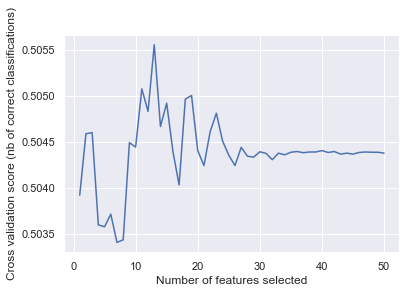

In [22]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

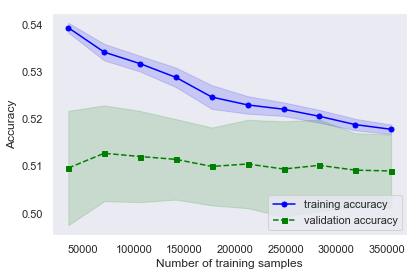

In [26]:
X_train = train_bernie[features].values
y_train = train_bernie['target_bernie'].values
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()


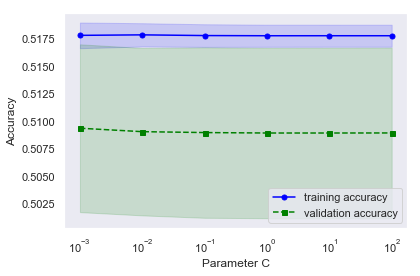

In [29]:

X_train = train_bernie[features].values
y_train = train_bernie['target_bernie'].values
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10,n_jobs =-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')

plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [38]:
#pipe_lr.get_params()

In [42]:
X_train = train_bernie[features].values[:1000]
y_train = train_bernie['target_bernie'].values[:1000]

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.591
{'svc__C': 1.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [44]:
X_train = train_bernie[features].values[:1000]
y_train = train_bernie['target_bernie'].values[:1000]

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1,probability =True))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='log_loss', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

KeyboardInterrupt: 

In [ ]:
X_train = train_bernie[features]
y_train = train_bernie['target_bernie']

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_train, y_train))